In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block
from bold_dementia.utils.iterables import unique

ATLAS = "gillig"
SOFT = False
ALPHA = config["alpha"]

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [3]:
expname = f"atlas-{ATLAS}_test_ols-cenanom"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
print(f"Loading matrices from {matrices_path}")
try:
    fdrmat = joblib.load(matrices_path / "pmat.joblib")
    tstats = joblib.load(matrices_path / "statmap.joblib")
except FileNotFoundError:
    print("Fetching results from resdf")

#n_AD = AD_matrices.shape[0]
#n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
labels = tuple(sorted(unique(atlas.macro_labels)))

Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-gillig_test_ols-cenanom


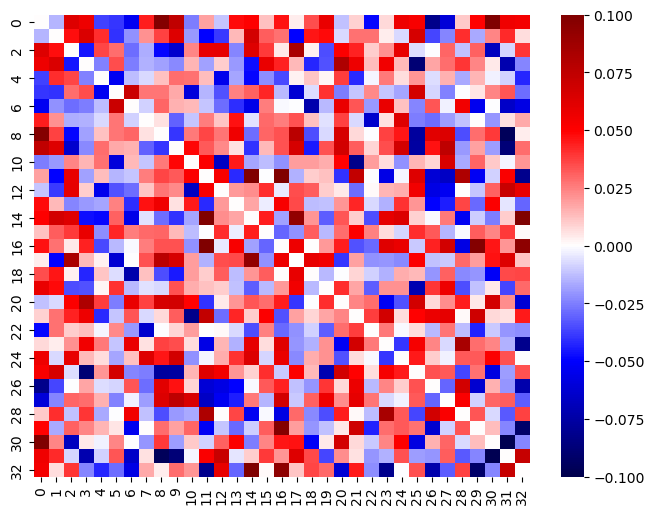

In [4]:
span = np.max(np.abs(thresholded_t))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(
    tstats,
    #xticklabels=labels,
    #yticklabels=labels,
    #title=f"{expname}\nthresholded t-values map",
    axes=ax,
    cmap="seismic",
    #grid=True,
    vmin=-span,
    vmax=span,
    #linewidths=0.1,
    #linecolor="gray",
    #linestyle="--"
)
#plt.setp(ax.xaxis.get_majorticklabels(), ha="center", rotation_mode="anchor")
plt.show()

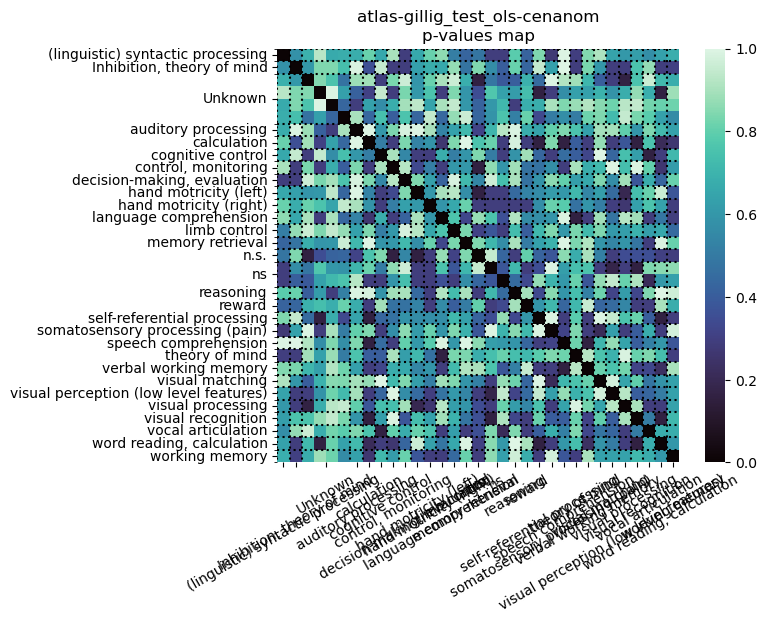

In [5]:
from bold_dementia.connectivity import plot_ordered_matrix

plot_matrix(fdrmat, atlas, bounds=(0, 1), cmap="mako")
plt.title(f"{expname}\np-values map")
plt.show()

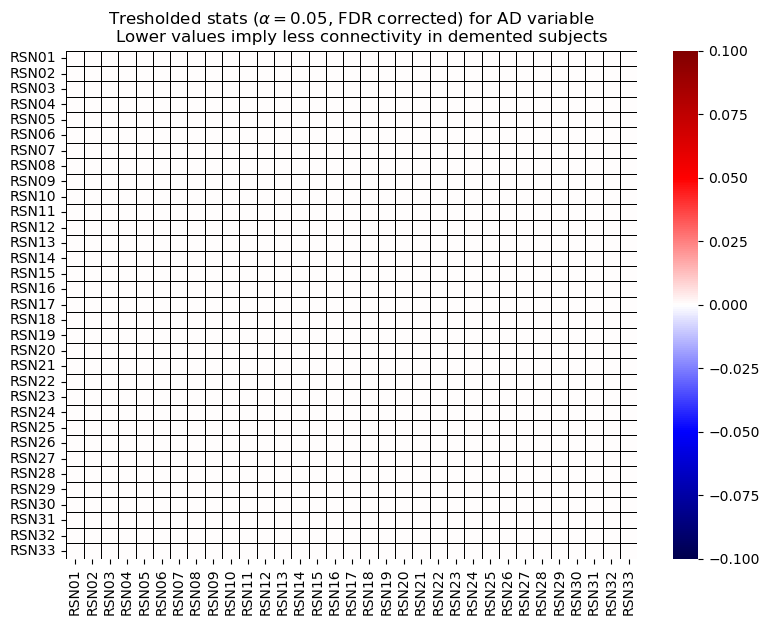

In [20]:

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)

plot_ordered_matrix(thresholded_t, atlas)

plt.title("Tresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

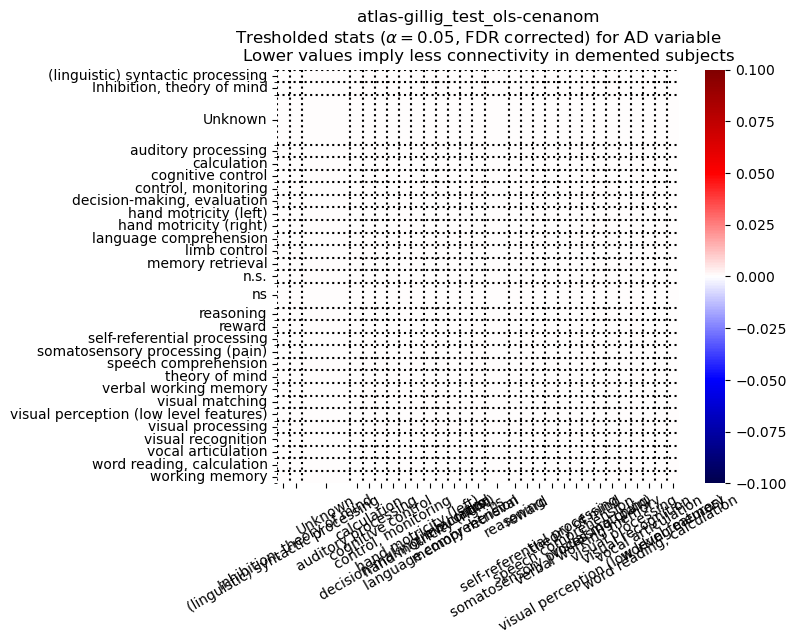

In [7]:
plot_matrix(thresholded_t, atlas)
plt.title(f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

In [8]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]

In [9]:
labels = [label for label in atlas.labels if label != "Background"]
dict(zip(labels, atlas.macro_labels))

{'RSN01': 'n.s.',
 'RSN02': 'reward',
 'RSN03': 'visual perception (low level features)',
 'RSN04': 'vocal articulation',
 'RSN05': 'decision-making, evaluation',
 'RSN06': '(linguistic) syntactic processing',
 'RSN07': 'somatosensory processing (pain)',
 'RSN08': 'Unknown',
 'RSN09': 'hand motricity (left)',
 'RSN10': 'hand motricity (right)',
 'RSN11': 'theory of mind',
 'RSN12': 'calculation',
 'RSN13': 'Inhibition, theory of mind',
 'RSN14': 'Unknown',
 'RSN15': 'visual recognition',
 'RSN16': 'memory retrieval',
 'RSN17': 'self-referential processing',
 'RSN18': 'ns',
 'RSN19': 'visual matching',
 'RSN20': 'limb control',
 'RSN21': 'cognitive control',
 'RSN22': 'language comprehension',
 'RSN23': 'auditory processing',
 'RSN24': 'verbal working memory',
 'RSN25': 'reasoning',
 'RSN26': 'ns',
 'RSN27': 'control, monitoring',
 'RSN28': 'working memory',
 'RSN29': 'speech comprehension',
 'RSN30': 'Unknown',
 'RSN31': 'Unknown',
 'RSN32': 'visual processing',
 'RSN33': 'word reading

In [10]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

(linguistic) syntactic processing           (0, 1)
Inhibition, theory of mind                  (1, 2)
Unknown                                     (2, 6)
auditory processing                         (6, 7)
calculation                                 (7, 8)
cognitive control                           (8, 9)
control, monitoring                        (9, 10)
decision-making, evaluation               (10, 11)
hand motricity (left)                     (11, 12)
hand motricity (right)                    (12, 13)
language comprehension                    (13, 14)
limb control                              (14, 15)
memory retrieval                          (15, 16)
n.s.                                      (16, 17)
ns                                        (17, 19)
reasoning                                 (19, 20)
reward                                    (20, 21)
self-referential processing               (21, 22)
somatosensory processing (pain)           (22, 23)
speech comprehension           

In [11]:
gen = block_block(block_mat, network_to_idx)
comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "npos", "nneg", "activation"])

In [12]:
comparisons_pv = comparisons.pivot(index="node_a", columns="node_b")

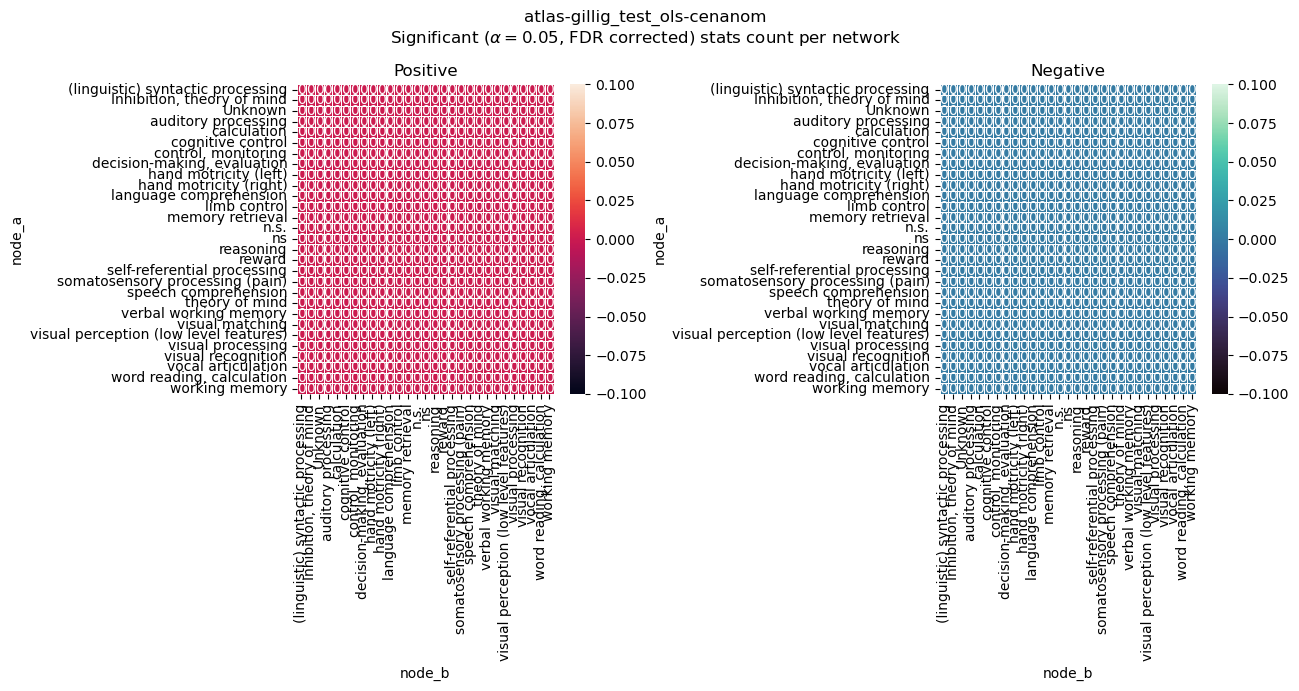

In [13]:
max_count = max(comparisons[["npos", "nneg"]].max())

heat_kwargs = {
    "xticklabels":unique_m,
    "yticklabels":unique_m,
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}

fig, axes = plt.subplots(1, 2, figsize=(13, 7))
sns.heatmap(comparisons_pv.loc[:, "npos"], **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive")

sns.heatmap(comparisons_pv.loc[:, "nneg"], **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative")
fig.suptitle(f"{expname}\nSignificant ($\\alpha = 0.05$, FDR corrected) stats count per network")
fig.tight_layout()
fig.show()

In [14]:
tuple(unique(atlas.macro_labels))

('n.s.',
 'reward',
 'visual perception (low level features)',
 'vocal articulation',
 'decision-making, evaluation',
 '(linguistic) syntactic processing',
 'somatosensory processing (pain)',
 'Unknown',
 'hand motricity (left)',
 'hand motricity (right)',
 'theory of mind',
 'calculation',
 'Inhibition, theory of mind',
 'visual recognition',
 'memory retrieval',
 'self-referential processing',
 'ns',
 'visual matching',
 'limb control',
 'cognitive control',
 'language comprehension',
 'auditory processing',
 'verbal working memory',
 'reasoning',
 'control, monitoring',
 'working memory',
 'speech comprehension',
 'visual processing',
 'word reading, calculation')

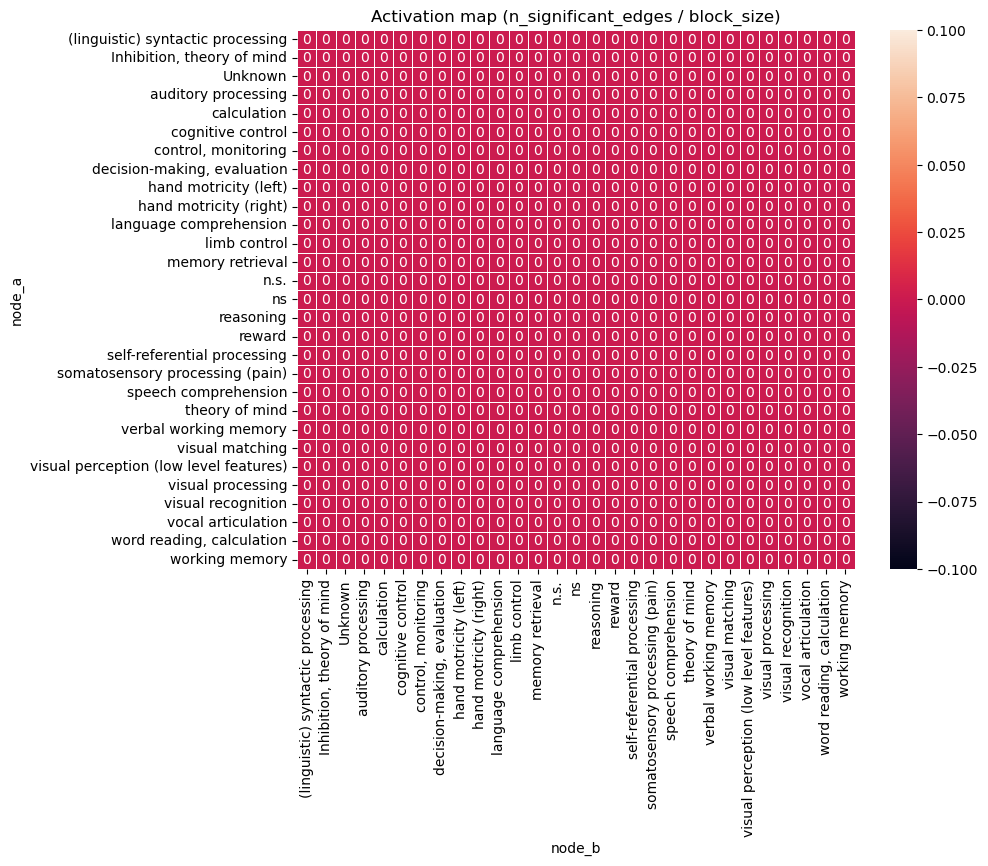

In [15]:
heat_k2 = heat_kwargs.copy()
heat_k2.pop("vmax")
plt.subplots(1, 1, figsize=(9, 7))
sns.heatmap(comparisons_pv.loc[:, "activation"], **heat_k2)
plt.title("Activation map (n_significant_edges / block_size)")
plt.show()

In [16]:
view = plotting.view_connectome(tstats, coords, edge_threshold="99%")
view.open_in_browser()

KeyboardInterrupt: 

In [ ]:
tstats.shape

(33, 33)